[Titanic feature engineering](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial)

[More feature engineering](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)

[More feature engineering](https://www.kaggle.com/code/nicapotato/titanic-feature-engineering)

[House Prices engineering](https://medium.com/swlh/explained-kaggle-housing-prices-feature-engineering-and-ridge-regression-88934ad37edc)


# Titanic Dataset: Feature Engineering

In the previous notebooks, we already saw two ways of improving classification performance on the Titanic dataset:

- we could use more complex models, such as Multi-layer Perceptrons, Random Forests or eXtreme Gradient Boosting.
- we could use hyperparameter optimization to tune the model's parameters.

In this notebook, we will see a third way of improving classification performance: feature engineering. Feature engineering is the process of using domain knowledge derive new features from the existing data. By adding domain knowledge, we can create new features that can help the model to learn patterns that it would not be able to learn otherwise. In this notebook, we will see how to create new features from the Titanic dataset and how to use them to improve the classification performance. We start again by loading raw data.

In [ ]:
import os

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    os.environ['DATA_DIRECTORY'] = '/content'
else:
    os.environ['DATA_DIRECTORY'] = '../../data'

data_directory = os.getenv('DATA_DIRECTORY')

In [ ]:
%%bash
if [ ! -f "$DATA_DIRECTORY/course-data.zip" ]; then
    wget "https://gitlab.com/api/v4/projects/52375047/jobs/artifacts/master/raw/data/course-data.zip?job=build_data_zip" -O "$DATA_DIRECTORY/course-data.zip"
    unzip "$DATA_DIRECTORY/course-data.zip" -d "$DATA_DIRECTORY"
fi

In [ ]:
import pandas as pd 

titanic_df = pd.read_csv(os.path.join(data_directory, 'titanic/train.csv'))
titanic_df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## Get Labels

After the loading the data, we first get the labels of the data. The labels are the target values that we want to predict. In this case, the labels show whether the passenger survived or not. We store the labels in a variable called `y_true`. This variable contains the "ground truth", or the true value, values that we want to predict. By comparing the predicted values of the model to the true values, we can evaluate the performance of the model.

In [286]:
y_true = titanic_df['Survived']
y_true

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

## Baseline performance

We start by evaluating the performance of the model on the data we preprocessed before. This gives us a baseline that we can improve using feature engineering. We use the same preprocessing steps as before, but we do not use any feature engineering. We use a Random Forest Classifier, and evaluate its performance.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

titanic_preprocessed_df = pd.read_csv(os.path.join(data_directory, 'titanic/train_preprocessed.csv'))
y_preprocessed_true = titanic_preprocessed_df['Survived']
titanic_preprocessed_df = titanic_preprocessed_df.drop('Survived', axis=1)

rf_model = RandomForestClassifier(n_estimators=300, random_state=42)

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(titanic_preprocessed_df, y_preprocessed_true, test_size=0.2, random_state=42)

rf_model.fit(X_train_base, y_train_base)

y_pred_base = rf_model.predict(X_test_base)
print(classification_report(y_test_base, y_pred_base))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       105
           1       0.76      0.74      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



# Missing values: imputation

In the previous notebook, we saw that the Titanic dataset contains missing values:

In [288]:
titanic_df.isnull().sum().to_frame()

0
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age          177
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin        687
Embarked       2

In the previous notebook, we used the SimpleImputer class from scikit to impute the `Age` variable with its `median` value. However, this does not take into account that several groups of passengers, may have different median ages. Let's look at which variables the `Age` variable has a high correlation with. These variables, we may need to take into account when imputing the `Age` variable.

In [289]:
titanic_all_corr = titanic_df.corr(numeric_only=True).abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
titanic_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
titanic_all_corr[titanic_all_corr['Feature 1'] == 'Age']

Feature 1    Feature 2  Correlation Coefficient
5        Age          Age                 1.000000
12       Age       Pclass                 0.369226
16       Age        SibSp                 0.308247
21       Age        Parch                 0.189119
26       Age         Fare                 0.096067
32       Age     Survived                 0.077221
36       Age  PassengerId                 0.036847

We see that `Age` variable has a high correlation with the `Pclass` and `SibSp` variables. This means that the `Age` variable may have different median values for different classes of passengers and passengers with a different number of siblings. Let's look at the median age for each class of passengers.

In [290]:
age_by_class = titanic_df.groupby('Pclass')['Age'].mean()
age_by_class.plot(kind='bar', title='Average Age by Class')

<Axes: title={'center': 'Average Age by Class'}, xlabel='Pclass'>

This shows that the `Age` variable has different median values for different classes of passengers. The passengers in first class have a much higher median age than the passengers in second and third class. If we further use the `Sex` variable, we can see that the median ages per class and gender are also different.

<Axes: title={'center': 'Median Age by Gender'}, xlabel='Pclass,Sex'>

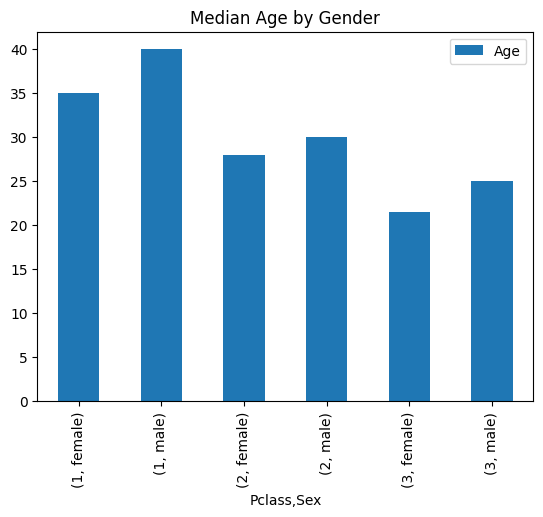

In [292]:
age_by_gender = titanic_df[["Age", "Pclass", "Sex"]].groupby(['Pclass','Sex']).median()
age_by_gender.plot(kind='bar', title='Median Age by Gender')

We can use these more specific groups based on social class and gender to impute the age values:

In [293]:
titanic_df["Age"] = titanic_df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median())).reset_index(level=[0,1], drop=True)

And check if there are any missing values left:

In [294]:
titanic_df.isnull().sum().to_frame()

0
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin        687
Embarked       2

## Missing values in Embarked

When we look at the passengers with missing values for the `Embarked` variable, we see there are two passengers with a missing value:

In [295]:
titanic_df[titanic_df['Embarked'].isnull()]

PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN

We see that both passengers have the same ticket id. This means that they probably have been traveling together. When we Google the name of the passengers, we find the following [information](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html).
We find the following information:

> Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28

So both Mrs Stone and her maid Amelie Icard embarked in Southampton. We can impute the missing values with the value `S`.

In [296]:
# Filling the missing values in Embarked with S
titanic_df['Embarked'] = titanic_df['Embarked'].fillna('S')

# Missing values in Cabin

The `Cabin` variable has a lot of missing values. Earlier, we encoded the `Cabin` value as a boolean value that indicated whether the cabin is known or not. However, we can also use the known cabins to derive new features. For example, we can use the first letter of the cabin to derive the deck of the cabin. Let's do this now, we will use the `M` value to encode the missing values:

In [297]:
titanic_df['Deck'] = titanic_df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
titanic_df.value_counts('Deck')

Deck
M    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

We can see that 687 passengers have a missing value for the `Cabin` and thus also for the `Deck` variable. However, for the passengers that do have deck information, we can use that information to say something about the survival rates of the passengers on that deck. Some decks were closer to the stairs and therefore have a higher survival rate. Decks were mostly separated per passenger class, but some were used by multiple passenger classes. 

![Titanic deck plan](./Titanic_side_plan.webp)

The deck plan looked like this:

- On the Boat Deck there were 6 rooms labeled as T, U, W, X, Y, Z but only the T cabin is present in the dataset
- A, B and C decks were only for 1st class passengers
- D and E decks were for all classes
- F and G decks were for both 2nd and 3rd class passengers
- From going A to G, distance to the staircase increases which might be a factor of survival

Let's look at the survival rates of the passengers on each deck:

In [298]:
titanic_df.groupby('Deck')['Survived'].mean().plot(kind='bar', title='Survival Rate by Deck')

<Axes: title={'center': 'Survival Rate by Deck'}, xlabel='Deck'>

In [299]:
titanic_df[titanic_df['Deck'] == 'T']

PassengerId  Survived  Pclass                          Name   Sex   Age  \
339          340         0       1  Blackwell, Mr. Stephen Weart  male  45.0   

     SibSp  Parch  Ticket  Fare Cabin Embarked Deck  
339      0      0  113784  35.5     T        S    T

In [300]:
total_per_deck_class = titanic_df.groupby(['Deck','Pclass'])['Pclass'].count()
total_by_deck = titanic_df['Deck'].value_counts()

class_percentage_per_deck = (total_per_deck_class / total_by_deck).unstack()
class_percentage_per_deck.plot(kind='bar', stacked=True, title='Class Percentage by Deck')

<Axes: title={'center': 'Class Percentage by Deck'}, xlabel='Deck'>

In [301]:
class_percentage_per_deck

Pclass         1         2         3
Deck                                
A       1.000000       NaN       NaN
B       1.000000       NaN       NaN
C       1.000000       NaN       NaN
D       0.878788  0.121212       NaN
E       0.781250  0.125000  0.093750
F            NaN  0.615385  0.384615
G            NaN       NaN  1.000000
M       0.058224  0.244541  0.697234
T       1.000000       NaN       NaN

In the plot and table above, we can see that on the A, B, C, and T decks there are only first class passengers. The D deck has passengers from the 1st and 2nd class. The E deck of all classes. The F deck has passengers from the 2nd and 3rd class. The G deck has only 3rd class passengers. To see whether the deck the passengers were in had an effect on their survival rate, we can plot the survival rates of the passengers on each deck:

In [302]:
survival_rate_per_deck = titanic_df.groupby('Deck')['Survived'].value_counts(normalize=True).unstack()
survival_rate_per_deck


Survived         0         1
Deck                        
A         0.533333  0.466667
B         0.255319  0.744681
C         0.406780  0.593220
D         0.242424  0.757576
E         0.250000  0.750000
F         0.384615  0.615385
G         0.500000  0.500000
M         0.700146  0.299854
T         1.000000       NaN

<Axes: title={'center': 'Survival Rate by Deck'}, xlabel='Deck'>

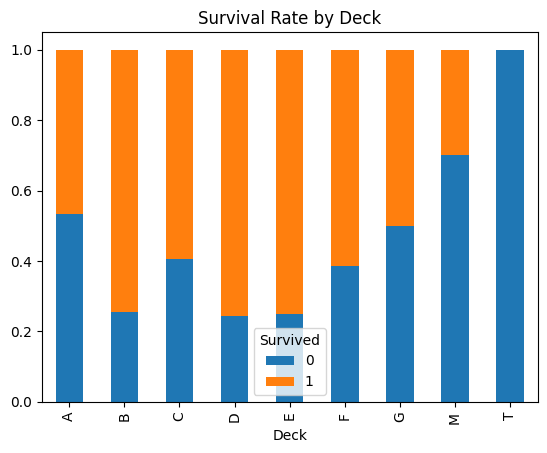

In [303]:
survival_rate_per_deck.plot(kind='bar', stacked=True, title='Survival Rate by Deck')

We can see that the deck the passengers were on had an effect on their survival rate. Passengers on the B, C, D, and E decks had a higher survival rate than passengers on the other decks. Passengers on the M deck had the lowest survival rate (the T cabin was on the boat deck and only had one passenger). Moreover passengers on the D and the E deck had similar survival rates. We can use the information about the survival rate per deck and the class distribution per deck to derive combined features:

- We will group the decks A, B, C, and T together, because they only have first class passengers.
- We will group the decks D and E together, because they have a similar class distribution and survival rate.
- We will group the decks F and G together, because they have a similar survival rate.
- We won't change the M deck, because it has a very different survival rate than the other decks.

Let's create these new features: 

In [304]:
titanic_df['Deck'] = titanic_df['Deck'].replace(['A', 'B', 'C', 'T'], 'ABC')
titanic_df['Deck'] = titanic_df['Deck'].replace(['D', 'E'], 'DE')
titanic_df['Deck'] = titanic_df['Deck'].replace(['F', 'G'], 'FG')

titanic_df['Deck'].value_counts()

Deck
M      687
ABC    122
DE      65
FG      17
Name: count, dtype: int64

## Categorical Features

### Encoding the categorical features

We can encode the categorical features in two ways:

- We can use one-hot encoding to encode the categorical features. This means that we create a new binary variable for each category of the categorical variable. For example, the `Sex` variable has two categories: `male` and `female`. We can encode this variable using one-hot encoding by creating two new variables: `Sex_male` and `Sex_female`. `Sex_male` variables will have a value of 1 if the passenger is male and 0 otherwise. 
- We can use label encoding to encode the categorical features. This means that we assign a unique integer value to each category of the categorical variable. For example, the `Embarked` variable has three categories: `S`, `C`, and `Q`. We can encode this variable using label encoding by assigning the value 0 to `S`, 1 to `C`, and 2 to `Q`.

In this notebook, we will use label encoding for the categorical features:

In [305]:
from sklearn.preprocessing import LabelEncoder

categorical_features = ["Sex", "Embarked", "Deck"]

for feature in categorical_features:
    label_encoder = LabelEncoder()
    titanic_df[feature] = label_encoder.fit_transform(titanic_df[feature])

titanic_df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0      1      0   
2                             Heikkinen, Miss. Laina    0  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.0      1      0   
4                           Allen, Mr. William Henry    1  35.0      0      0   

             Ticket     Fare Cabin  Embarked  Deck  
0         A/5 21171   7.2500   NaN         2     3  
1          PC 17599  71.2833   C85         0     0  
2  STON/O2. 3101282   7.9250   NaN         2     3  
3            113803  53.1000  C123         2     0  
4            373450   8.0500   NaN         2     3

## Derive Family Sizes

Another feature we can derive from the Titanic dataset is the family size of the passengers. We can derive the family size by adding the `SibSp` and `Parch` variables. The `SibSp` variable shows the number of siblings and spouses the passenger had on board. The `Parch` variable shows the number of parents and children the passenger had on board. By adding these two variables, we can derive the family size of the passenger. In addition, from the family size, we can derive whether the passenger was alone on board or not. Let's derive these features now:

In [306]:
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1
titanic_df['IsAlone'] = 0
titanic_df.loc[titanic_df['FamilySize'] == 1, 'IsAlone'] = 1

<Axes: title={'center': 'Survival Rate by IsAlone'}, xlabel='IsAlone'>

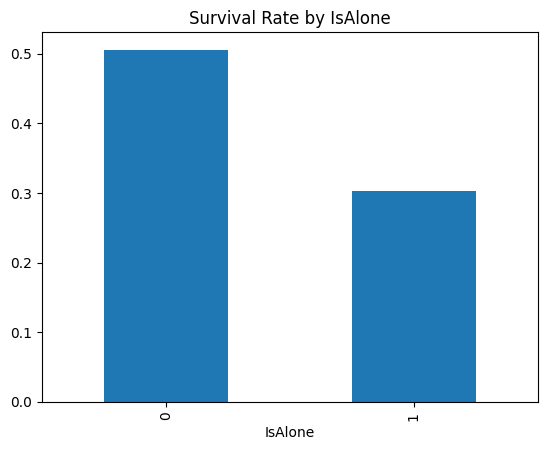

In [307]:
titanic_df.groupby('IsAlone')['Survived'].mean().plot(kind='bar', title='Survival Rate by IsAlone')

We can see that passengers traveling alone had a lower survival rate than passengers traveling with family. 

<Axes: title={'center': 'Survival Rate by Family Size'}, xlabel='FamilySize'>

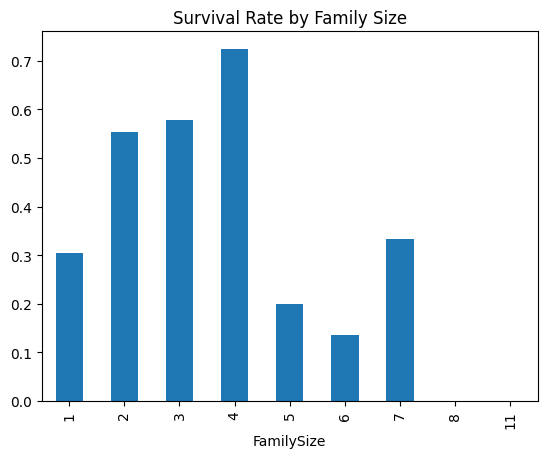

In [308]:
titanic_df.groupby('FamilySize')['Survived'].mean().plot(kind='bar', title='Survival Rate by Family Size')

In addition, we can see that the family size of the passengers had an effect on their survival rate. Passengers traveling with 1 to 4, or 7 family members had a higher survival rate than passengers traveling alone or with more than 3 family members. 

## Using the length of the names as a feature

We can use the length of the names of the passengers as a feature. The length of the name may indicate the social status of the passenger. For example, passengers with longer names may have a higher social status. Let's create this feature:

In [309]:
titanic_df["Name_length"] = titanic_df["Name"].apply(len)

If we plot the length of the Name grouped by social class, we see that the first class passengers have longer names than the second and third class passengers. Also second class passengers have longer names than third class passengers. This means that the length of the name may be a good feature to use in the model.

<Axes: title={'center': 'Average Name Length by Class'}, xlabel='Pclass'>

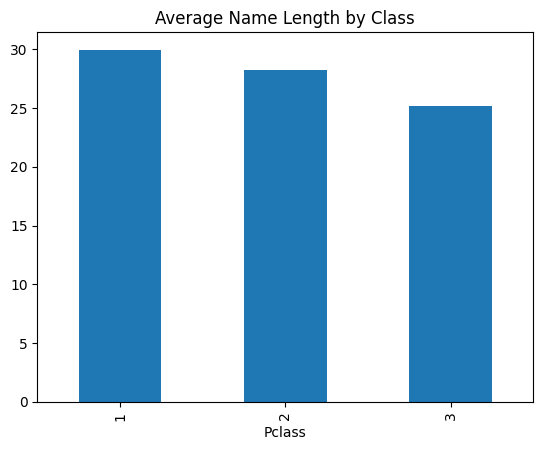

In [310]:
titanic_df.groupby('Pclass')['Name_length'].mean().plot(kind='bar', title='Average Name Length by Class')

We can check if the length of the name is correlated with the survival rate:

<Axes: title={'center': 'Average Name Length by Survival'}, xlabel='Survived'>

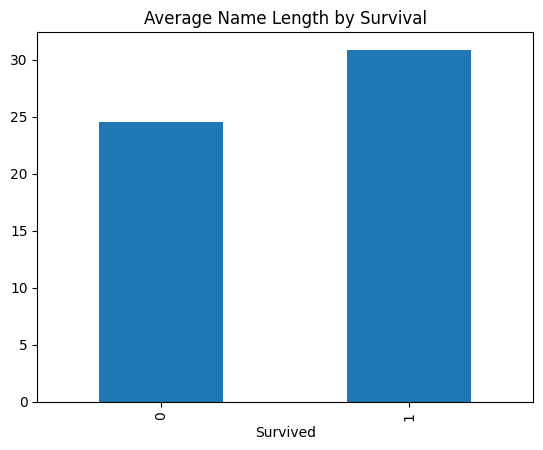

In [311]:
titanic_df.groupby('Survived')['Name_length'].mean().plot(kind='bar', title='Average Name Length by Survival')

The plot shows indeed that people with longer names have a higher survival rate. 

## Drop the processed columns

We can now drop the columns that we have used to derive the new features. We can also drop the columns that we do not need anymore. 

In [312]:
titanic_df = titanic_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin','Survived'])

## Performance after feature engineering

Now we have added several features and encoded the categorical columns, we can evaluate the performance of the model with feature engineering. Below, we compare the base model performance with the performance after feature engineering.

In [313]:
rf_model = RandomForestClassifier(n_estimators=300, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(titanic_df, y_true, test_size=0.2, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("--- Base Model (Without feature engineering) ---")
print(classification_report(y_test_base, y_pred_base))
print("--- Model with feature engineering ---")
print(classification_report(y_test, y_pred))

--- Base Model (Without feature engineering) ---
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       105
           1       0.76      0.74      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

--- Model with feature engineering ---
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       105
           1       0.80      0.81      0.81        74

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



The classification report shows that by using feature engineering, we were able to improve the performance of the model. The precision, recall, and F1-score of the model have all improved. This shows that feature engineering can be a powerful tool to improve the performance of the model.

This also shows if we look at the feature importances returned by the Random Forest model:

<Axes: title={'center': 'Feature Importances'}, ylabel='feature_name'>

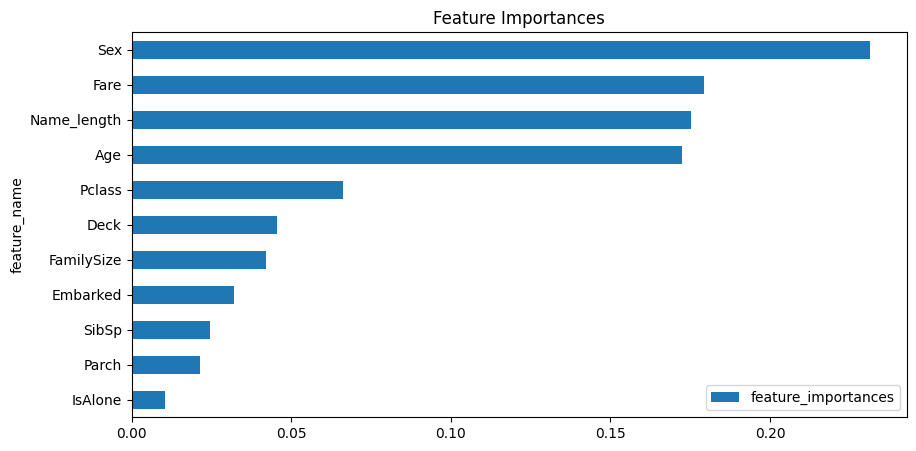

In [314]:
feature_importances = pd.DataFrame({"feature_name": rf_model.feature_names_in_, "feature_importances": rf_model.feature_importances_})

feature_importances.sort_values(by="feature_importances", ascending=True).plot(x="feature_name", y="feature_importances", kind="barh",  title="Feature Importances", figsize=(10, 5))


We see here that among the six most important features, two are derived features, namely, the `Deck` and `Name_length` features. This shows that feature engineering can be a powerful tool to improve the performance of the model.

# Conclusion

In this notebook, we saw how to use feature engineering to improve the performance of the model. We saw that by using domain knowledge, we can derive new features from the existing data that can help the model to learn patterns that it would not be able to learn otherwise. We saw that by using feature engineering, we were able to improve the performance of the model on the Titanic dataset. We saw that the precision, recall, and F1-score of the model have all improved. This shows that feature engineering can be a powerful tool to improve the performance of the model.

You now have several tools to improve the performance of the model on the Titanic dataset:

- you can use more complex models, such as Multi-layer Perceptrons, Random Forests or eXtreme Gradient Boosting.
- you can use hyperparameter optimization to tune the model's parameters.
- you can use feature engineering to derive new features from the existing data.